In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

# Image Classification with TensorFlow

Image classification is a common task for deep learning and neural networks.  The raw features coming in are the pixel values.  These are simple enough to deal with, but it is difficult to connect pixel values to determining whether an image is of a cat.  Older methods used a lot of clever filters, but the current best-of-breed algorithms simply throw a lot of linear algebra at the problem.

In this project, I will build a series of models to classify a series of images into one of ten classes. For expediency, these images are pretty small ($32\times32\times3$).  This can make classification a bit tricky&mdash;human performance is only about 94%.

A training set and a validation set are available under the same folder.  Ground truth values are provided for the training set.  I will train the models on the training set, and then make predictions for each of the validation images.

## Data Pre-processing

The `CIFAR-10` data set are used.  It consists of 60,000 images, each $32\times32$ color pixels, each belonging to one of ten classes. We will download the [data](https://www.cs.toronto.edu/~kriz/cifar.html).

The data are downloaded, extracted, and pre-processed:

In [2]:
# download data
from six.moves import urllib
import os
DATA_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filename = DATA_URL.split('/')[-1]
if not os.path.exists(filename):
    urllib.request.urlretrieve(DATA_URL, filename)

In [3]:
# extract data
import tarfile
dest_dir = './data/'
extract_dir = os.path.join(dest_dir, 'cifar-10-batches-py')
if not os.path.exists(extract_dir):
    os.makedirs(dest_dir)
    tarfile.open(filename,'r:gz').extractall(dest_dir)

In [4]:
# data loading and pre-processing
import pickle
def unpickle(file):
    '''load the binary file by unpickling'''
    with open(file, 'rb') as fo:
        dict1 = pickle.load(fo, encoding='latin1')
    return dict1

def load_one(file):
    '''load single batch, reshape the images to 32X32X3,
       convert to [0,1)'''
    data = unpickle(file)
    X = (data['data'].reshape([-1,3,32,32])
                     .transpose(0,2,3,1)
                     .astype("float"))
    X = X/256.0 # convert to [0,1)
    Y = np.array(data['labels'])
    return X, Y

def load_all(ROOT):
    '''load all batches'''
    xs = []
    ys = []
    for i in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (i, ))
        X, Y = load_one(f)
        xs.append(X)
        ys.append(Y)
    X_train = np.vstack(xs)
    y_train = np.hstack(ys)
    X_test, y_test = load_one(os.path.join(ROOT,'test_batch'))
    return X_train, X_test, y_train, y_test

# getting the data from the folder
train_images, validation_images, train_labels, validation_labels = load_all(extract_dir)

print('Train images shape: ', train_images.shape)
print('Train labels shape: ', train_labels.shape)
print('Validation images shape: ', validation_images.shape)
print('Validation labels shape: ', validation_labels.shape)

Train images shape:  (50000, 32, 32, 3)
Train labels shape:  (50000,)
Validation images shape:  (10000, 32, 32, 3)
Validation labels shape:  (10000,)


The images are stored as four-dimensional arrays.  The first index indicates the image number, the second and third the $x$ and $y$ positions, and the fourth index the color channel.  Each pixel color is a floating point number between 0 and 1.  This convention makes viewing the images with matplotlib possible:

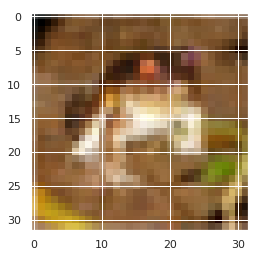

In [5]:
matplotlib.pyplot.imshow(train_images[0])

The classes have already been numbered 0-9; those numbers are stored in the vector `train_labels`.

In [6]:
train_labels[0]

6

The human-readable names associated with this classes are

In [7]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

so you can see that the image above is a frog.  (Now you see it!)

### TensorFlow resets

The cell below is a handy tensorflow reset function I will use in this project.

In [17]:
import tensorflow as tf

sess = None

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

def reset_vars():
    sess.run(tf.global_variables_initializer())
    
reset_tf()

## Perceptual Delta

Since we already have a number of labeled images, a simple approach would be to measure the difference between two images, and choose the label corresponding to nearby images.  To do this, we need to develop a metric determine the distance between two images.  We'll make the simplifying (and completely wrong) assumption that this is just the average difference between the colors of the corresponding pixels in the two images.

While we could just take RMS difference of the red, green, and blue pixels, let's be slightly more sophisticated and look at human vision for a metric.  After all, we're pretty good at image classifications, so there might be some useful optimization here.

It turns out that modeling human perception is [extraordinarily complicated](https://en.wikipedia.org/wiki/Color_difference#CIEDE2000).  We're going to use a [simplified model](https://www.compuphase.com/cmetric.htm):

$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

This accounts for the fact that our eyes are most sensitive to green and least sensitive to red, and that perception is not constant with hue.

I will build a graph that takes in a series of images, as well as a base image, and returns the average $\Delta C$ over all pixels between the base image and each image in the series.  It will help us later on to make the generation of this graph a function.

### Delta_func

I will use the first validation image as an example to calculate its distance with all of the training images.

In [9]:
#this is basis for doing arithmetic in tensorflows 
import tensorflow as tf

g = tf.get_default_graph()
sess = tf.Session()
images = tf.placeholder(dtype = tf.float32,shape =(None,32,32,3))
base = tf.Variable(tf.random_uniform([32,32,3],minval=0,maxval=1))
# defining the delta_func so that the code can be reused later on
def delta_func(images,base):
    sqs_diff = tf.squared_difference(images,base)
    #need to divide by 2 instead of multiply by 0.5
    r_mean = tf.add(images[:,:,:,0]/2,base[:,:,0]/2)
    tot_sum = tf.sqrt(2*sqs_diff[:,:,:,0]+4*sqs_diff[:,:,:,1]+3*sqs_diff[:,:,:,2]+
                      r_mean*(sqs_diff[:,:,:,0]-sqs_diff[:,:,:,2]))
    return tf.reduce_mean(tot_sum,(1,2))
delta_c = delta_func(images,base)
deltas = sess.run(delta_c,{images:train_images,base:validation_images[0]})

From these, find the 100 closest images from the training set to this image.

In [7]:
np.argsort(deltas)[:100]

array([27912, 23437, 47732, 25053, 29251,  3616, 43445,  5555, 46911,
       16269, 45450, 47893, 27833, 41078,  6385, 32788,  2108, 44366,
       40857, 18619, 32596, 43840, 42187,  7982, 47629, 14298, 29521,
       15860, 48219, 25953, 24522,  1363, 32891, 18702, 19759, 16247,
        5859,  3303, 37982,  5463,  9738,  8448,  4881, 14185, 18347,
       35163, 13960, 39700,  7837, 36899, 31793, 11317, 29615, 10413,
       45178, 16021, 40089,  6224, 42620, 14932, 27543, 18868, 46440,
       17882, 44700, 11784, 24729, 37317, 45209, 10709, 17501, 10440,
       46378, 32430, 15659, 21665, 25680, 30766, 46671, 43551, 32145,
       20364, 11465, 40643, 12229, 23235,  6878, 36196, 33346,  2986,
       22061, 16130, 43791,  8380, 17921, 45047,  1582, 32047,  3060,
        1015])

> **Aside:** Essentially, we've started to implement a k-nearest neighbors algorithm, using this perceptual distance as our metric.  If we ran the difference between all of the validation images and each of the training images, we could make a prediction from the nearest images for each.

## Smallest delta model

Instead of comparing each validation image to each training image, let's generate a "typical" image for each class.  This typical image will be the one that minimizes the total perceptual delta from all training images in this class.  We could do that through some clever averaging, but let's treat it as a minimization problem.  

This problem will have two steps, the first step is to train a typical image for each class in the training set, the second will be to make predictions on the validation set.  These predictions will be based on the closest "typical" image trained in the first step.

Make the typical image a TensorFlow variable, starting with random pixel values.

### With delta_func

In [12]:
#this block of code uses the delta_func defined above
LEARNING_RATE = 0.5
Iterations = 500
delta_c = delta_func(images,base)
error = tf.reduce_mean(delta_c)
train = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error)

Now, use gradient descent to optimize the typical image to minimize the error.  Do this for each of the ten classes.

In [ ]:
from tqdm import tqdm_notebook
reset_vars()
n = np.zeros([10,32,32,3])
for i in tqdm_notebook(range(10)):
    for j in tqdm_notebook(range(Iterations)):
        sess.run(train,feed_dict={images:train_images[train_labels==i]})
    n[i] = sess.run(base)

In [36]:
predict = [np.argmin(sess.run(delta_c,{images:n,base:a})) 
           for a in validation_images]
# calculate the accuracy
accuracy_2 = (sum(np.array(predict) == validation_labels) / 
                                validation_labels.shape[0] * 100)

print('Accuracy for smallest delta model is:',
      '%0.2f'%(accuracy_2,),'%',sep = ' ')

Accuracy for smallest delta model is: 25.13 %


Make a prediction for each validation image based on which typical image is nearest under our distance metric.  Return a list of 10,000 integers, representing the predicted class of each validation image. The overall accuracy is poor for this model at only **25.13%** .

## Softmax model

Looking only at the smallest distance is throwing some information away.  We would expect some classes to have more variation that others.  Also, we would expect correlation between the classes&mdash;a small distance to *cat* is probably more likely for *dog* than for *airplane*.

Instead of a trying to work out these effects heuristically, let the computer do it.  Build a softmax model that takes as input features the distances from all ten typical images and makes a class prediction from those.  Again, use this to predict the class for each of the validation images.

Calculate the distance from the 10 "typical" images:

In [37]:
def get_dist(data):
    dist = []
    dist.append([sess.run(delta_c,{images:n,base:a}) for a in data])
    return np.vstack(dist)
dist_train = get_dist(train_images)
dist_test = get_dist(validation_images)

Split the training data set for a small test set, build a softmax model:

In [38]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(dist_train, train_labels, 
                                                 test_size=0.02, random_state=0)

reset_tf()
Iterations = 10000
LEARNING_RATE = 0.8

x = tf.placeholder(tf.float32, [None,10], name="features")
y_labels = tf.placeholder(tf.int64, [None,], name="labels")

W = tf.Variable(tf.zeros([10, 10]), name="weights")
b = tf.Variable(tf.zeros([10]), name="biases")
y = tf.matmul(x, W) + b

y_labels_one = tf.one_hot(y_labels, 10)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, 
                                                              labels=y_labels_one))
train = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1),
                                           y_labels),
                                  tf.float32))

In [41]:
reset_vars()
for i in tqdm_notebook(range(Iterations)):
    sess.run(train,
             feed_dict={x: X_train, 
                        y_labels: y_train})
    if i % 1000 == 0:
        l, a = sess.run([loss, accuracy],
                       feed_dict={x: X_test, 
                                  y_labels: y_test})
        print("Loss : %0.5f , Accuracy: %0.5f" % (l,a))

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

Loss : 2.29979 , Accuracy: 0.10000
Loss : 2.11447 , Accuracy: 0.21900
Loss : 2.08222 , Accuracy: 0.24300
Loss : 2.06510 , Accuracy: 0.25800
Loss : 2.05338 , Accuracy: 0.26400
Loss : 2.04446 , Accuracy: 0.26800
Loss : 2.03725 , Accuracy: 0.27100
Loss : 2.03118 , Accuracy: 0.27200
Loss : 2.02590 , Accuracy: 0.27300
Loss : 2.02121 , Accuracy: 0.27300


We can see that the softmax does improve the acurracy in the training set. Lets see how the model performs on validation set:

In [43]:
predicted = tf.argmax(y,1)
predict = sess.run(predicted,{x:dist_test})
# calculate the accuracy
accuracy_3 = (sum(np.array(predict) == validation_labels) / 
                                validation_labels.shape[0] * 100)

print('Accuracy for softmax model is:',
      '%0.2f'%(accuracy_3,),'%',sep = ' ')

Accuracy for smallest delta model is: 28.34 %


Overall, considering the distance with all the 10 typical images increases the accuracy to **28.34 %** . However, the improvement is quite small.

## Fully-connected model

The previous model still makes the assumption that this distance metric is the right measure to use.  In this problem, we'll give this up.  Build a multi-layer fully-connected neural network that takes the pixel values as input and yields a class prediction as output.

### Two hidden layers with mini-batch processing / boostraping / early stopping

I will use the dropout and early stopping to prevent the overfitting. The fully-connected model will have 2 hidden layers. Furthermore, the training utilizes the mini-batch to accelerate the process. Boostraping is also applied to help the training process.

In [51]:
# prepare the foler for the early stopping
if not os.path.exists('my_model'):
    os.makedir('my_model')

In [44]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_images, train_labels, 
                                                 test_size=0.1, random_state=0)

reset_tf()
image_size = 32 * 32 * 3
Iterations = 60000
LEARNING_RATE = 0.5
hidden_size = 50
batch_size = 100
count_size = 10 #parameter to control the early stopping rate
count = 0 #early stopping counter
loss_min = 100 #store the running loss minima
dropout = 0.5 #dropout rate

x = tf.placeholder(tf.float32, [None, image_size], name="pixels")
y_labels = tf.placeholder(tf.int64, [None,], name="labels")
#training label is for dropout test, a boolean value to differentiate
#training vs testing
training = tf.placeholder(tf.bool, name="training")

drop1 = tf.layers.dropout(x, dropout, training=training)
hidden1 = tf.layers.dense(drop1, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=image_size**-0.5))

drop2 = tf.layers.dropout(hidden1, dropout, training=training)
hidden2 = tf.layers.dense(drop2, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))

drop3 = tf.layers.dropout(hidden2, dropout, training=training)
y = tf.layers.dense(drop3, 10, activation=None, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))

y_labels_one = tf.one_hot(y_labels, 10)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, 
                                                              labels=y_labels_one))
train = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1),
                                           y_labels),
                                  tf.float32))
#make sure this step comes at the very end
saver = tf.train.Saver(tf.global_variables())

In [45]:
from tqdm import tqdm_notebook
reset_vars()
for i in tqdm_notebook(range(Iterations)):
    #minibatch training with boostraping
    j = np.random.choice(len(y_train), batch_size, replace=True)
    sess.run(train,
             feed_dict={x: X_train[j].reshape(-1,image_size), 
                        y_labels: y_train[j],
                        training: True})
    if i % 3000 == 0:
        l, a = sess.run([loss, accuracy],
                       feed_dict={x: X_test.reshape(-1,image_size), 
                                  y_labels: y_test,
                                  training: False})
        print("Loss : %0.5f , Accuracy: %0.5f" % (l,a))
        if count >= count_size:
            saver.restore(sess,saver.last_checkpoints[-1])
            break
        else:
            if l < loss_min:
                loss_min = l
                count = 0
                saver.save(sess,'my_model/my_model',global_step=i)
            else:
                count += 1

HBox(children=(IntProgress(value=0, max=60000), HTML(value='')))

Loss : 2.32958 , Accuracy: 0.09660
Loss : 1.85219 , Accuracy: 0.32260
Loss : 1.79033 , Accuracy: 0.35700
Loss : 1.75280 , Accuracy: 0.37020
Loss : 1.75138 , Accuracy: 0.37320
Loss : 1.72416 , Accuracy: 0.37700
Loss : 1.73156 , Accuracy: 0.36920
Loss : 1.71180 , Accuracy: 0.38740
Loss : 1.71484 , Accuracy: 0.38460
Loss : 1.71115 , Accuracy: 0.38140
Loss : 1.70565 , Accuracy: 0.38360
Loss : 1.70129 , Accuracy: 0.39060
Loss : 1.69582 , Accuracy: 0.39100
Loss : 1.69721 , Accuracy: 0.39540
Loss : 1.69618 , Accuracy: 0.39500
Loss : 1.69542 , Accuracy: 0.38980
Loss : 1.68423 , Accuracy: 0.39400
Loss : 1.68407 , Accuracy: 0.39860
Loss : 1.68935 , Accuracy: 0.39560
Loss : 1.68070 , Accuracy: 0.39080


In [46]:
predicted = tf.argmax(y,1)
predict = sess.run(predicted,{x:validation_images.reshape(-1,image_size),
                              training: False})
accuracy_4 = (sum(np.array(predict) == validation_labels) / 
                                validation_labels.shape[0] * 100)

print('Accuracy for fully-connected model is:',
      '%0.2f'%(accuracy_4,),'%',sep = ' ')

Accuracy for smallest delta model is: 41.56 %


The fully-connected model does have a great improvement over the previous models. The accuracy increases to **39.08 %** on the training set and **41.56 %** on the validation set.

### keras version

Keras is a great platform for performing deep learning with neural networks. I also implement the fully-connected model with 2 hiddent and 3 dropout layers in the Keras framework. Early stopping is applied to prevent over fitting as well:

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_images, train_labels, 
                                                 test_size=0.02, random_state=0)
reset_tf()
image_size = 32 * 32 * 3
Iterations = 60000
hidden_size = 50
batch_size = 100
dropout = 0.5 #dropout rate

def one_hot(arr, nc):
    """one hot encode array, assume numerical labels"""
    one_hot = np.zeros((arr.shape[0], nc))
    for i, ele in enumerate(arr):
        one_hot[i][ele] = 1
    return one_hot
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

input_layer = keras.layers.Input(shape=(32,32,3))
x = keras.layers.Flatten()(input_layer)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(hidden_size, activation='sigmoid')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(hidden_size, activation='sigmoid')(x)
x = keras.layers.Dropout(0.5)(x)
y = keras.layers.Dense(10, activation='softmax')(x)

model = keras.models.Model(inputs=input_layer, outputs=y)
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./my_model/keras_model.hdf5',
                                               monitor='val_loss',
                                               verbose=1, save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                              verbose=1, min_delta=.001)
history = model.fit(X_train, y_train,
                    epochs=500,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpointer, earlystopping])
predicted = model.predict(validation_images)
predict = np.argmax(predicted,1)

In [7]:
accuracy_4_k = (sum(predict == validation_labels) / 
                                validation_labels.shape[0] * 100)

print('Accuracy for fully-connected model with Keras is:',
      '%0.2f'%(accuracy_4_k,),'%',sep = ' ')

Accuracy for fully-connected model with Keras is: 36.27 %


The fully-connected model with Kera also provides a similar result. The accuracy increases to **35.40 %** on the training set and **36.27 %** on the validation set. The small difference might lie on the different training parameters.

## Convolutional model

Convolutional neural networks have had a lot of success in image classification.  I will build a neural network with 3 convolutional layers, 3 Max-pooling layers, a fully-connected layer with 2 hidden layers to improve the performance.

### 3 Convolution/Max-pooling plus 2 fully-connected

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_images, train_labels, 
                                                 test_size=0.02, random_state=0)

reset_tf()
image_size = 32
n_channels = 3
image_size_flat = 32 * 32 * 3
filt_size = [5,5]
Iterations = 60000
LEARNING_RATE = 0.5
hidden_size = 50
batch_size = 50 #smaller number train much faster
count_size = 8 #parameter to control the early stopping rate
count = 0 #early stopping counter
loss_min = 100 #store the running loss minima
dropout = 0.5 #dropout rate

x = tf.placeholder(tf.float32, [None, image_size, image_size, n_channels], 
                                               name="pixels")
y_labels = tf.placeholder(tf.int64, [None,], name="labels")
#training label is for dropout test, a boolean value to differentiate
#training vs testing
training = tf.placeholder(tf.bool, name="training")
#first layer of convolution and max_cooling
out_conv1 = tf.layers.conv2d(x, 48, filt_size, padding='same',
                             activation = tf.nn.relu, name="convolution1")
out_pool1 = tf.layers.max_pooling2d(out_conv1, pool_size=(2, 2), 
                                   strides=(2,2), padding='same')
#second layer of convolution and max_cooling
out_conv2 = tf.layers.conv2d(out_pool1, 96, [1,1], padding='same', 
                            activation=tf.nn.relu, name="convolution2")
out_pool2 = tf.layers.max_pooling2d(out_conv2, pool_size=(2, 2), 
                                   strides=(2,2), padding='same')
#third layer of convolution and max_cooling
out_conv3 = tf.layers.conv2d(out_pool2, 144, filt_size, padding='same', 
                            activation=tf.nn.relu, name="convolution3")
out_pool3 = tf.layers.max_pooling2d(out_conv3, pool_size=(2, 2), 
                                   strides=(2,2), padding='same')
#flatten out the images
out_pool_reshape = tf.reshape(out_pool3, [-1, out_pool3.shape[1:].num_elements()])

#full connected model with dropout
drop1 = tf.layers.dropout(out_pool_reshape, dropout, training=training)
hidden1 = tf.layers.dense(drop1, hidden_size, activation=tf.nn.relu)

drop2 = tf.layers.dropout(hidden1, dropout, training=training)
hidden2 = tf.layers.dense(drop2, hidden_size, activation=tf.nn.relu)

drop3 = tf.layers.dropout(hidden2, dropout, training=training)
y = tf.layers.dense(drop3, 10, activation=None)

softmax = tf.nn.softmax_cross_entropy_with_logits_v2
loss = tf.reduce_mean(softmax(logits=y, 
                              labels=tf.one_hot(y_labels, 10)))
train = tf.train.AdamOptimizer().minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1),
                                           y_labels),
                                  tf.float32))
#make sure this step comes at the very end
saver = tf.train.Saver(tf.global_variables())

In [9]:
from tqdm import tqdm_notebook
reset_vars()
for i in tqdm_notebook(range(Iterations)):
    #minibatch training with boostraping
    j = np.random.choice(len(y_train), batch_size, replace=True)
    sess.run(train,
             feed_dict={x: X_train[j], 
                        y_labels: y_train[j],
                        training: True})
    if i % 1000 == 0:
        l, a = sess.run([loss, accuracy],
                       feed_dict={x: X_test, 
                                  y_labels: y_test,
                                  training: False})
        print("Loss : %0.5f , Accuracy: %0.5f" % (l,a))
        if count >= count_size:
            saver.restore(sess,saver.last_checkpoints[-1])
            break
        else:
            if l < loss_min:
                loss_min = l
                count = 0
                #make sure there is a local folder called 'my_model'
                saver.save(sess,'my_model/my_model',global_step=i)
            else:
                count += 1

HBox(children=(IntProgress(value=0, max=60000), HTML(value='')))

Loss : 2.30383 , Accuracy: 0.09600
Loss : 1.64179 , Accuracy: 0.39800
Loss : 1.42007 , Accuracy: 0.46600
Loss : 1.30282 , Accuracy: 0.53700
Loss : 1.22545 , Accuracy: 0.56700
Loss : 1.18845 , Accuracy: 0.56300
Loss : 1.13927 , Accuracy: 0.59500
Loss : 1.13569 , Accuracy: 0.58800
Loss : 1.05090 , Accuracy: 0.63600
Loss : 1.04019 , Accuracy: 0.62900
Loss : 1.02505 , Accuracy: 0.65300
Loss : 0.97560 , Accuracy: 0.65600
Loss : 0.98128 , Accuracy: 0.64700
Loss : 0.95615 , Accuracy: 0.67100
Loss : 0.95077 , Accuracy: 0.66500
Loss : 0.93515 , Accuracy: 0.68100
Loss : 0.87743 , Accuracy: 0.67900
Loss : 0.95984 , Accuracy: 0.65800
Loss : 0.89669 , Accuracy: 0.68500
Loss : 0.89472 , Accuracy: 0.70200
Loss : 0.91620 , Accuracy: 0.67800
Loss : 0.91718 , Accuracy: 0.68200
Loss : 0.87746 , Accuracy: 0.68900
Loss : 0.85581 , Accuracy: 0.71400
Loss : 0.85413 , Accuracy: 0.71900
Loss : 0.84346 , Accuracy: 0.69800
Loss : 0.82681 , Accuracy: 0.72400
Loss : 0.86103 , Accuracy: 0.69900
Loss : 0.87224 , Acc

In [10]:
saver.restore(sess,saver.last_checkpoints[-1])
predicted = tf.argmax(y,1)
predict = sess.run(predicted,{x:validation_images,
                              training: False})
accuracy_5 = (sum(predict == validation_labels) / 
                                validation_labels.shape[0] * 100)

print('Accuracy for convolutional model is:',
      '%0.2f'%(accuracy_5,),'%',sep = ' ')

INFO:tensorflow:Restoring parameters from my_model/my_model-29000
Accuracy for convolutional model is: 71.78 %


The convolutional model does give a great boost in the metics. The accuracy increases to **72.90 %** in the training set, and **71.78 %** in the validation set.

### keras version

In [ ]:
#it seems that only one keras session a time. Need to close the notebook
#if another version of keras needs to run
from tensorflow import keras
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_images, train_labels, 
                                                 test_size=0.02, random_state=0)
#the target of the label needs to convert beforehand
def one_hot(arr, nc):
    """one hot encode array, assume numerical labels"""
    one_hot = np.zeros((arr.shape[0], nc))
    for i, ele in enumerate(arr):
        one_hot[i][ele] = 1
    return one_hot
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

reset_tf()
image_size = 32 * 32 * 3
epochs = 100
hidden_size = 50
batch_size = 100
dropout = 0.5 #dropout rate

input_layer = keras.layers.Input(shape=(32,32,3))
#convolution layer
x = keras.layers.Conv2D(filters = 48,kernel_size=(3,3),padding='same',
                        activation='relu')(input_layer)
x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                              padding='same')(x)
x = keras.layers.Conv2D(filters = 96,kernel_size=(1,1),padding='same',
                        activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                              padding='same')(x)
x = keras.layers.Conv2D(filters = 144,kernel_size=(3,3),padding='same',
                        activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                              padding='same')(x)
#full-connected layer
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(hidden_size, activation='sigmoid')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(hidden_size, activation='sigmoid')(x)
x = keras.layers.Dropout(0.5)(x)
y = keras.layers.Dense(10, activation='softmax')(x)

model = keras.models.Model(inputs=input_layer, outputs=y)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./my_model/keras_conv.hdf5',
                                               monitor='val_loss',
                                               verbose=1, save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                              verbose=1, min_delta=.01)
#the whole data feed to model 'epochs' times. Each time on 'batch_size'
history = model.fit(X_train, y_train,
                    epochs=500,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpointer, earlystopping])
predicted = model.predict(validation_images)
predict = np.argmax(predicted,1)

In [7]:
accuracy_5_k = (sum(predict == validation_labels) / 
                                validation_labels.shape[0] * 100)

print('Accuracy for convolutional model with Keras is:',
      '%0.2f'%(accuracy_5_k,),'%',sep = ' ')

Accuracy for convolutional model with Keras is: 75.84 %


The convolutional model with keras does give a comparable results with a slight increase. The accuracy increases to **74.40 %** in the training set, and **75.84 %** in the validation set.

## Transfer learning

### Prepare Deep Dream Model

In transfer learning, we use a network trained on one data set to provide a starting point for the modeling of other data.  As we are trying to model color images, we should look for another network trained on color images.  We will use a famouse network: the `GoogLeNet` network.

The following cell will download the saved network, if necessary, and load it into the current graph.

In [28]:
import os
from urllib.request import urlopen
import zipfile

data_url = "http://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip"
data_dir = os.path.expanduser("~/inception/5h/")
file_path = os.path.join(data_dir, 'inception5h.zip')

if not os.path.exists(file_path):
    # Check if the download directory exists, otherwise create it.
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    # Download
    with open(file_path, "wb") as local_file:
        local_file.write(urlopen(data_url).read())
    # Extract
    zipfile.ZipFile(file_path, mode="r").extractall(data_dir)

path = os.path.join(data_dir, "tensorflow_inception_graph.pb")
with tf.gfile.FastGFile(path, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

In a transfer learning setup, we will use the first part of the trained network to process the original images, and then train a network to make predictions from the output of the trained network.  There are several ways to accomplish this.

One approach is to connect the new layers to the output of the existing layers.  Data will flow through the pre-trained layers as well as those added.  In the training step, only the new layers should be marked as trainable.

However, this can be a bit wasteful when multiple epochs of training will be undertaken.  With a smaller data set, such as this, it can be more efficient to pre-calculate the *latent vectors* that are the output of the pre-trained network.  These can be stored and used as input for training a smaller, separate network to make the predictions.

Images are to be fed to the `GoogLeNet` network's `input` tensor.  We can get that with the `get_tensor_by_name()` function:

In [29]:
googlenet_input = sess.graph.get_tensor_by_name("input:0")

In [30]:
googlenet_input.shape

TensorShape(None)

If we check the shape of this tensor, we'll see that it's `TensorShape(None)`.  You can feed any tensor into it, and it will compute something.  To get a reasonable output, however, you should feed in the same format that it was trained with, a four-dimensional tensor of shape `[?, 224, 224, 3]`.

This implies that we need to upscale our images from $32\times32$ to $224\times224$.  There are a number of ways to do this; We will use `scipy.ndimage.zoom()` with the `order=1` parameter.  (Higher orders produce better results, but will take significantly longer!)  The `GoogLeNet` network was trained with pixel values from 0 to 255, so we'll want to scale up the image values appropriately.

We will also need to pick a layer from the `GoogLeNet` model to use as the input to your layers.  Since `GoogLeNet` was trained on images much like our data set, we can use a layer near the end.  We will use the `avgpool0` layer (shape `[?, 1, 1, 1024]`).

It may make sense to do the rescaling and latent vector calculation at the same time, to avoid storing the (somewhat large) rescaled images unnecessarily.  We also need to save those latent vectors to disk, to avoid the need to repeat this calculation later.

### Latent Vector

In [31]:
layer_tensor = sess.graph.get_tensor_by_name("avgpool0:0")

In [32]:
import scipy as sp
from tqdm import tqdm_notebook
batch_size = 100

def get_latent_vector(images,batch_size):
    '''split to batch, zoom to 224, scale to [0,255],
       calculate the latent vector'''
    latent_vector = []
    #split data into batches to prevent memory problems
    for t in tqdm_notebook(np.split(images,images.shape[0]/batch_size,axis=0)):
        conv_zoom = sp.ndimage.zoom(t, [1,224/32,224/32,1],order=1) #zoom
        conv_scale = np.clip(conv_zoom*256,0.0,255.0).astype(np.uint8) #to [0,255]
        latent_vector.append(sess.run(layer_tensor,
                                      feed_dict={googlenet_input:conv_scale}))
    return np.vstack(latent_vector)

In [ ]:
latent_vector_train = get_latent_vector(train_images,batch_size)

In [ ]:
latent_vector_test = get_latent_vector(validation_images,batch_size)

In [15]:
import dill
dill.dump(latent_vector_train,open('lv_train.dill','wb'))
dill.dump(latent_vector_test,open('lv_test.dill','wb'))

In [ ]:
# comment out the following lines if need to load latent vectors
# latent_vector_train = dill.load(open('lv_train.dill','rb'))
# latent_vector_test = dill.load(open('lv_test.dill','rb'))

With the latent vectors calculated, we can use them as input to train a small neural network to make the final predictions. We are going to use the fully-connected model that we implemented above with 3 layers:

### Full connected with 3 layers

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(latent_vector_train, train_labels, 
                                                 test_size=0.02, random_state=0)

reset_tf()
image_size = 1 * 1 * 1024
Iterations = 60000
LEARNING_RATE = 0.5
hidden_size = 1024
batch_size = 100
count_size = 20 #parameter to control the early stopping rate
count = 0 #early stopping counter
loss_min = 100 #store the running loss minima
dropout = 0.5 #dropout rate

x = tf.placeholder(tf.float32, [None, image_size], name="pixels")
y_labels = tf.placeholder(tf.int64, [None,], name="labels")
#training label is for dropout test, a boolean value to differentiate
#training vs testing
training = tf.placeholder(tf.bool, name="training")

drop1 = tf.layers.dropout(x, dropout, training=training)
hidden1 = tf.layers.dense(drop1, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=image_size**-0.5))

drop2 = tf.layers.dropout(hidden1, dropout, training=training)
hidden2 = tf.layers.dense(drop2, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))

drop3 = tf.layers.dropout(hidden2, dropout, training=training)
y = tf.layers.dense(drop3, 10, activation=None, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))

y_labels_one = tf.one_hot(y_labels, 10)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, 
                                                              labels=y_labels_one))
train = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1),
                                           y_labels),
                                  tf.float32))
#make sure this step comes at the very end
saver = tf.train.Saver(tf.global_variables())

In [17]:
from tqdm import tqdm_notebook
reset_vars()
for i in tqdm_notebook(range(Iterations)):
    #minibatch training with boostraping
    j = np.random.choice(len(y_train), batch_size, replace=True)
    sess.run(train,
             feed_dict={x: X_train[j].reshape(-1,image_size), 
                        y_labels: y_train[j],
                        training: True})
    if i % 1000 == 0:
        l, a = sess.run([loss, accuracy],
                       feed_dict={x: X_test.reshape(-1,image_size), 
                                  y_labels: y_test,
                                  training: False})
        print("Loss : %0.5f , Accuracy: %0.5f" % (l,a))
        if count >= count_size:
            saver.restore(sess,saver.last_checkpoints[-1])
            break
        else:
            if l < loss_min:
                loss_min = l
                count = 0
                #make sure there is a local folder called 'my_model'
                saver.save(sess,'my_model/my_model',global_step=i)
            else:
                count += 1

HBox(children=(IntProgress(value=0, max=60000), HTML(value='')))

Loss : 10.91583 , Accuracy: 0.09800
Loss : 0.56959 , Accuracy: 0.79700
Loss : 0.51469 , Accuracy: 0.80600
Loss : 0.50238 , Accuracy: 0.82100
Loss : 0.49833 , Accuracy: 0.82000
Loss : 0.49239 , Accuracy: 0.81700
Loss : 0.49978 , Accuracy: 0.82000
Loss : 0.49387 , Accuracy: 0.81500
Loss : 0.48213 , Accuracy: 0.82400
Loss : 0.49490 , Accuracy: 0.81900
Loss : 0.47844 , Accuracy: 0.82000
Loss : 0.47311 , Accuracy: 0.82100
Loss : 0.48770 , Accuracy: 0.82400
Loss : 0.46803 , Accuracy: 0.82900
Loss : 0.48936 , Accuracy: 0.81600
Loss : 0.46626 , Accuracy: 0.82500
Loss : 0.48125 , Accuracy: 0.82500
Loss : 0.46067 , Accuracy: 0.83300
Loss : 0.46510 , Accuracy: 0.83500
Loss : 0.45722 , Accuracy: 0.83100
Loss : 0.44403 , Accuracy: 0.83300
Loss : 0.45854 , Accuracy: 0.84000
Loss : 0.44354 , Accuracy: 0.83900
Loss : 0.45808 , Accuracy: 0.83400
Loss : 0.44900 , Accuracy: 0.83600
Loss : 0.45067 , Accuracy: 0.83600
Loss : 0.45956 , Accuracy: 0.82900
Loss : 0.44352 , Accuracy: 0.84100
Loss : 0.46120 , Ac

In [18]:
saver.restore(sess,saver.last_checkpoints[-1])
predicted = tf.argmax(y,1)
predict = sess.run(predicted,{x:latent_vector_test.reshape(-1,image_size),
                              training: False})
accuracy_6 = (sum(predict == validation_labels) / 
                                validation_labels.shape[0] * 100)

print('Accuracy for transfer learning model is:',
      '%0.2f'%(accuracy_6,),'%',sep = ' ')

INFO:tensorflow:Restoring parameters from my_model/my_model-59000
Accuracy for transfer learning model is: 85.97 %


The transfer learning model does a excellent job in predicting the image labels. The accuracy achieves **86.00 %** in the training set, and **85.97 %** in the validation set!